# Transfer learning with TensorFlow Part 3: Scaling up(food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101(101 total classes of food).

Our goal is to beat the original Food101 paper

with 10% of the training data(leveraging the power of deep learning).

 Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf


Our baseline to beat is 50.76% accuracy across 101 classes.



In [ ]:
# Check to see if we're using a GPU

!nvidia-smi


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different taks, let's download them.

In [70]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-17 16:02:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-17 16:02:34 (78.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [71]:
# Import series of helper functions for our notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir ="101_food_classes_10_percent/train/"

test_dir="101_food_classes_10_percent/test/"

--2021-05-17 11:46:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.139.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   110MB/s    in 14s     

2021-05-17 11:47:14 (108 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 i

In [ ]:
# Setup data inputs
import tensorflow as tf 

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)# don't shuffle test data for predictions analysis 


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10 % of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to  build data augmentation right into the model

* Built a headless(no top layers) Functional EfficienteNetB0 backboned_model ( we'll create our own output layer
* Compile our model

* Feature extract for 5 passes(5 epochs on the train dataset and  validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_Callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)


In [ ]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup  data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
   # Preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
                                
], name ="data_augmentation")

In [ ]:
# Setup the base model and freese its layers(this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Setup model architecture with trainable top layers

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)# augment images(only happens during training phase)
x = base_model(x, training=False)# put the base model in inference mode so weights need to stay frozen, stay frozen

x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we've created

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile 

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# fit

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick)
                                           validation_data =test_data,
                                           validation_steps=int(0.35 * len(test_data)),# validate on only 15% of the data during training
                                           callbacks = [checkpoint_Callback])
                                                                

Epoch 1/5
237/237 [==============================] - 208s 729ms/step - loss: 4.0094 - accuracy: 0.1402 - val_loss: 2.4577 - val_accuracy: 0.4552
Epoch 2/5
237/237 [==============================] - 148s 622ms/step - loss: 2.4523 - accuracy: 0.4454 - val_loss: 2.0394 - val_accuracy: 0.5050
Epoch 3/5
237/237 [==============================] - 137s 578ms/step - loss: 2.0231 - accuracy: 0.5269 - val_loss: 1.8571 - val_accuracy: 0.5394
Epoch 4/5
237/237 [==============================] - 129s 543ms/step - loss: 1.7899 - accuracy: 0.5671 - val_loss: 1.7898 - val_accuracy: 0.5437
Epoch 5/5
237/237 [==============================] - 130s 547ms/step - loss: 1.6344 - accuracy: 0.6011 - val_loss: 1.7282 - val_accuracy: 0.5547


In [ ]:
# Evaluate on the whole test dataset

feature_extraction_results = model.evaluate(test_data)

feature_extraction_results

790/790 [==============================] - 156s 197ms/step - loss: 1.7139 - accuracy: 0.5543


[1.7139323949813843, 0.5542970299720764]

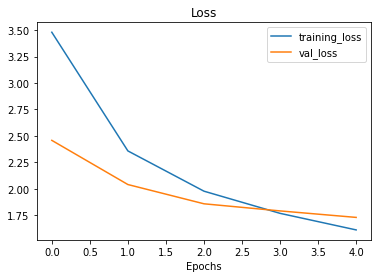

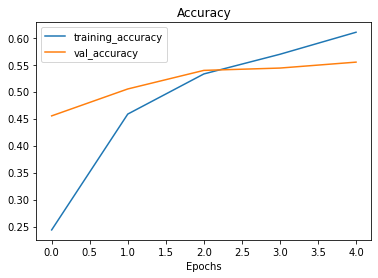

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> **question:** What do these curves suggest? Hint:
ideally, thw two curves should be very similar

to each other, if not  it may suggest that our nodel is overfitting(perfoming too well on the training data and not genralizing to unsee data)

## Fine-tuning

In [ ]:
# Unfreese all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the las 5

for layer in base_model.layers[:-5]:
  layer.trainable= False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),# learnig rate lowered by 10x
              metrics=["accuracy"])



In [ ]:

# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model

for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs(feature extraction), this is the total number of epochs we'r after(5 + 5 = 10)

# Fine-tune our model

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])



Epoch 5/10
237/237 [==============================] - 107s 419ms/step - loss: 1.4243 - accuracy: 0.6411 - val_loss: 1.8885 - val_accuracy: 0.5077
Epoch 6/10
237/237 [==============================] - 94s 393ms/step - loss: 1.2600 - accuracy: 0.6660 - val_loss: 1.8740 - val_accuracy: 0.5162
Epoch 7/10
237/237 [==============================] - 91s 381ms/step - loss: 1.1892 - accuracy: 0.6804 - val_loss: 1.9003 - val_accuracy: 0.5109
Epoch 8/10
237/237 [==============================] - 89s 374ms/step - loss: 1.1008 - accuracy: 0.7056 - val_loss: 1.8903 - val_accuracy: 0.5124
Epoch 9/10
237/237 [==============================] - 88s 370ms/step - loss: 1.0467 - accuracy: 0.7232 - val_loss: 1.8805 - val_accuracy: 0.5146
Epoch 10/10
237/237 [==============================] - 87s 364ms/step - loss: 0.9704 - accuracy: 0.7465 - val_loss: 1.9018 - val_accuracy: 0.5114


In [ ]:
# Evaluate on the whole test dataset

all_classes_10_percent_fine_tune_results = model.evaluate(test_data)



790/790 [==============================] - 156s 198ms/step - loss: 1.5895 - accuracy: 0.5823


In [ ]:
all_classes_10_percent_fine_tune_results

[1.5894889831542969, 0.5822574496269226]

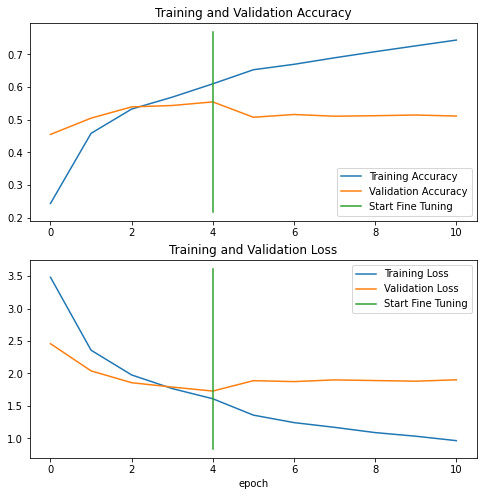

In [ ]:
# Compare the histories of feacture extraction model with fine-tuning model

compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving  and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tunning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


**Note:** Loading the model with the following cell will output  a large amount of warnings, there is a thread tracking, however it seems according to the tensorflow documentation, loading warningd can be ignored

In [ ]:
# load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model and compare perfomance to pre-saved model

loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 157s 197ms/step - loss: 1.5895 - accuracy: 0.5823


In [ ]:
loaded_model_results

[1.5894889831542969, 0.5822574496269226]

In [ ]:



# The results from our loaded_model(above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.5894889831542969, 0.5822574496269226]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize then later find out which prediction were the "most" wrong.

In [ ]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-05-17 11:49:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.12.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   130MB/s    in 0.3s    

2021-05-17 11:49:09 (130 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:


# Load in saved model

model= tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test_data)

results_dowloaded_model = model.evaluate(test_data)


790/790 [==============================] - 1514s 2s/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

In [ ]:
# Make predictions with model

preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 1520s 2s/step


In [ ]:
len(test_data)

790

In [ ]:
790*32

25280

In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# what' the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let' see what the first 10 predictions look like
preds_probs[:100]

array([[5.9541684e-02, 3.5742883e-06, 4.1377503e-02, ..., 1.4138888e-09,
        8.3532301e-05, 3.0897935e-03],
       [9.6401691e-01, 1.3753222e-09, 8.4779091e-04, ..., 5.4285556e-05,
        7.8362828e-12, 9.8465669e-10],
       [9.5925945e-01, 3.2533986e-05, 1.4866831e-03, ..., 7.1889338e-07,
        5.4399641e-07, 4.0275536e-05],
       ...,
       [9.5300126e-01, 5.9010291e-10, 3.7327823e-03, ..., 5.5091816e-05,
        7.8630464e-08, 3.0027579e-03],
       [6.8923803e-03, 1.4121592e-03, 9.8610416e-02, ..., 4.9489073e-02,
        1.1610915e-06, 4.9151917e-04],
       [1.1994669e-02, 1.4812164e-07, 9.2526978e-01, ..., 1.8893177e-05,
        1.1529819e-09, 1.4260170e-04]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])


(array([5.95416836e-02, 3.57428826e-06, 4.13775034e-02, 1.06607523e-09,
        8.16161005e-09, 8.66415917e-09, 8.09286178e-07, 8.56529311e-07,
        1.98594207e-05, 8.09792596e-07, 3.17283311e-09, 9.86754685e-07,
        2.85326882e-04, 7.80504883e-10, 7.42311066e-04, 3.89169145e-05,
        6.47421211e-06, 2.49777895e-06, 3.78913974e-05, 2.06786510e-07,
        1.55386806e-05, 8.15082956e-07, 2.62308754e-06, 2.00108843e-07,
        8.38293261e-07, 5.42168846e-06, 3.73914031e-06, 1.31505757e-08,
        2.77616247e-03, 2.80520071e-05, 6.85631607e-10, 2.55751092e-05,
        1.66892205e-04, 7.64089958e-10, 4.04536608e-04, 1.31508768e-08,
        1.79577773e-06, 1.44484000e-06, 2.30629742e-02, 8.24686140e-07,
        8.53668610e-07, 1.71385364e-06, 7.05265393e-06, 1.84022966e-08,
        2.85536601e-07, 7.94853077e-06, 2.06820914e-06, 1.85254066e-07,
        3.36205197e-08, 3.15226847e-04, 1.04110459e-05, 8.54501081e-07,
        8.47418129e-01, 1.05555300e-05, 4.40947275e-07, 3.740436

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's a 101 prediction probabilities)

print(f"Number of prediction probabilities for sample 0:{len(preds_probs[0])} ")
print(f"What prediction probability sample 0 looks like:\n{preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilities for sample 0:101 
What prediction probability sample 0 looks like:
[5.95416836e-02 3.57428826e-06 4.13775034e-02 1.06607523e-09
 8.16161005e-09 8.66415917e-09 8.09286178e-07 8.56529311e-07
 1.98594207e-05 8.09792596e-07 3.17283311e-09 9.86754685e-07
 2.85326882e-04 7.80504883e-10 7.42311066e-04 3.89169145e-05
 6.47421211e-06 2.49777895e-06 3.78913974e-05 2.06786510e-07
 1.55386806e-05 8.15082956e-07 2.62308754e-06 2.00108843e-07
 8.38293261e-07 5.42168846e-06 3.73914031e-06 1.31505757e-08
 2.77616247e-03 2.80520071e-05 6.85631607e-10 2.55751092e-05
 1.66892205e-04 7.64089958e-10 4.04536608e-04 1.31508768e-08
 1.79577773e-06 1.44484000e-06 2.30629742e-02 8.24686140e-07
 8.53668610e-07 1.71385364e-06 7.05265393e-06 1.84022966e-08
 2.85536601e-07 7.94853077e-06 2.06820914e-06 1.85254066e-07
 3.36205197e-08 3.15226847e-04 1.04110459e-05 8.54501081e-07
 8.47418129e-01 1.05555300e-05 4.40947275e-07 3.74043666e-05
 3.53067117e-05 3.24895445e-05 6.73152826e-0

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
# esto me devuelve un vector columna con la posicion de la maxima probabilidad para cada registro
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?

len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we  need to compare them to the original test dataset labels.

In [ ]:
# actualmente el test_data esta envuelto como un tensorflow batch dataset 
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [ ]:
# To get our labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,...0, 0](one hot encode), we want the index value where the "1" occurs

y_labels[:10] # look at the first 10

# podemos comparar debido a que cuando cargamos el test data desactivamos el shuffle, ahora podemos comparar manzanas con manzanas

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order our  test labels array to find the accuracy score

In [ ]:
results_dowloaded_model

[1.8027191162109375, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results

import numpy as np

np.isclose(results_dowloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# get a list of class names

class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import confusion_matrix


# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


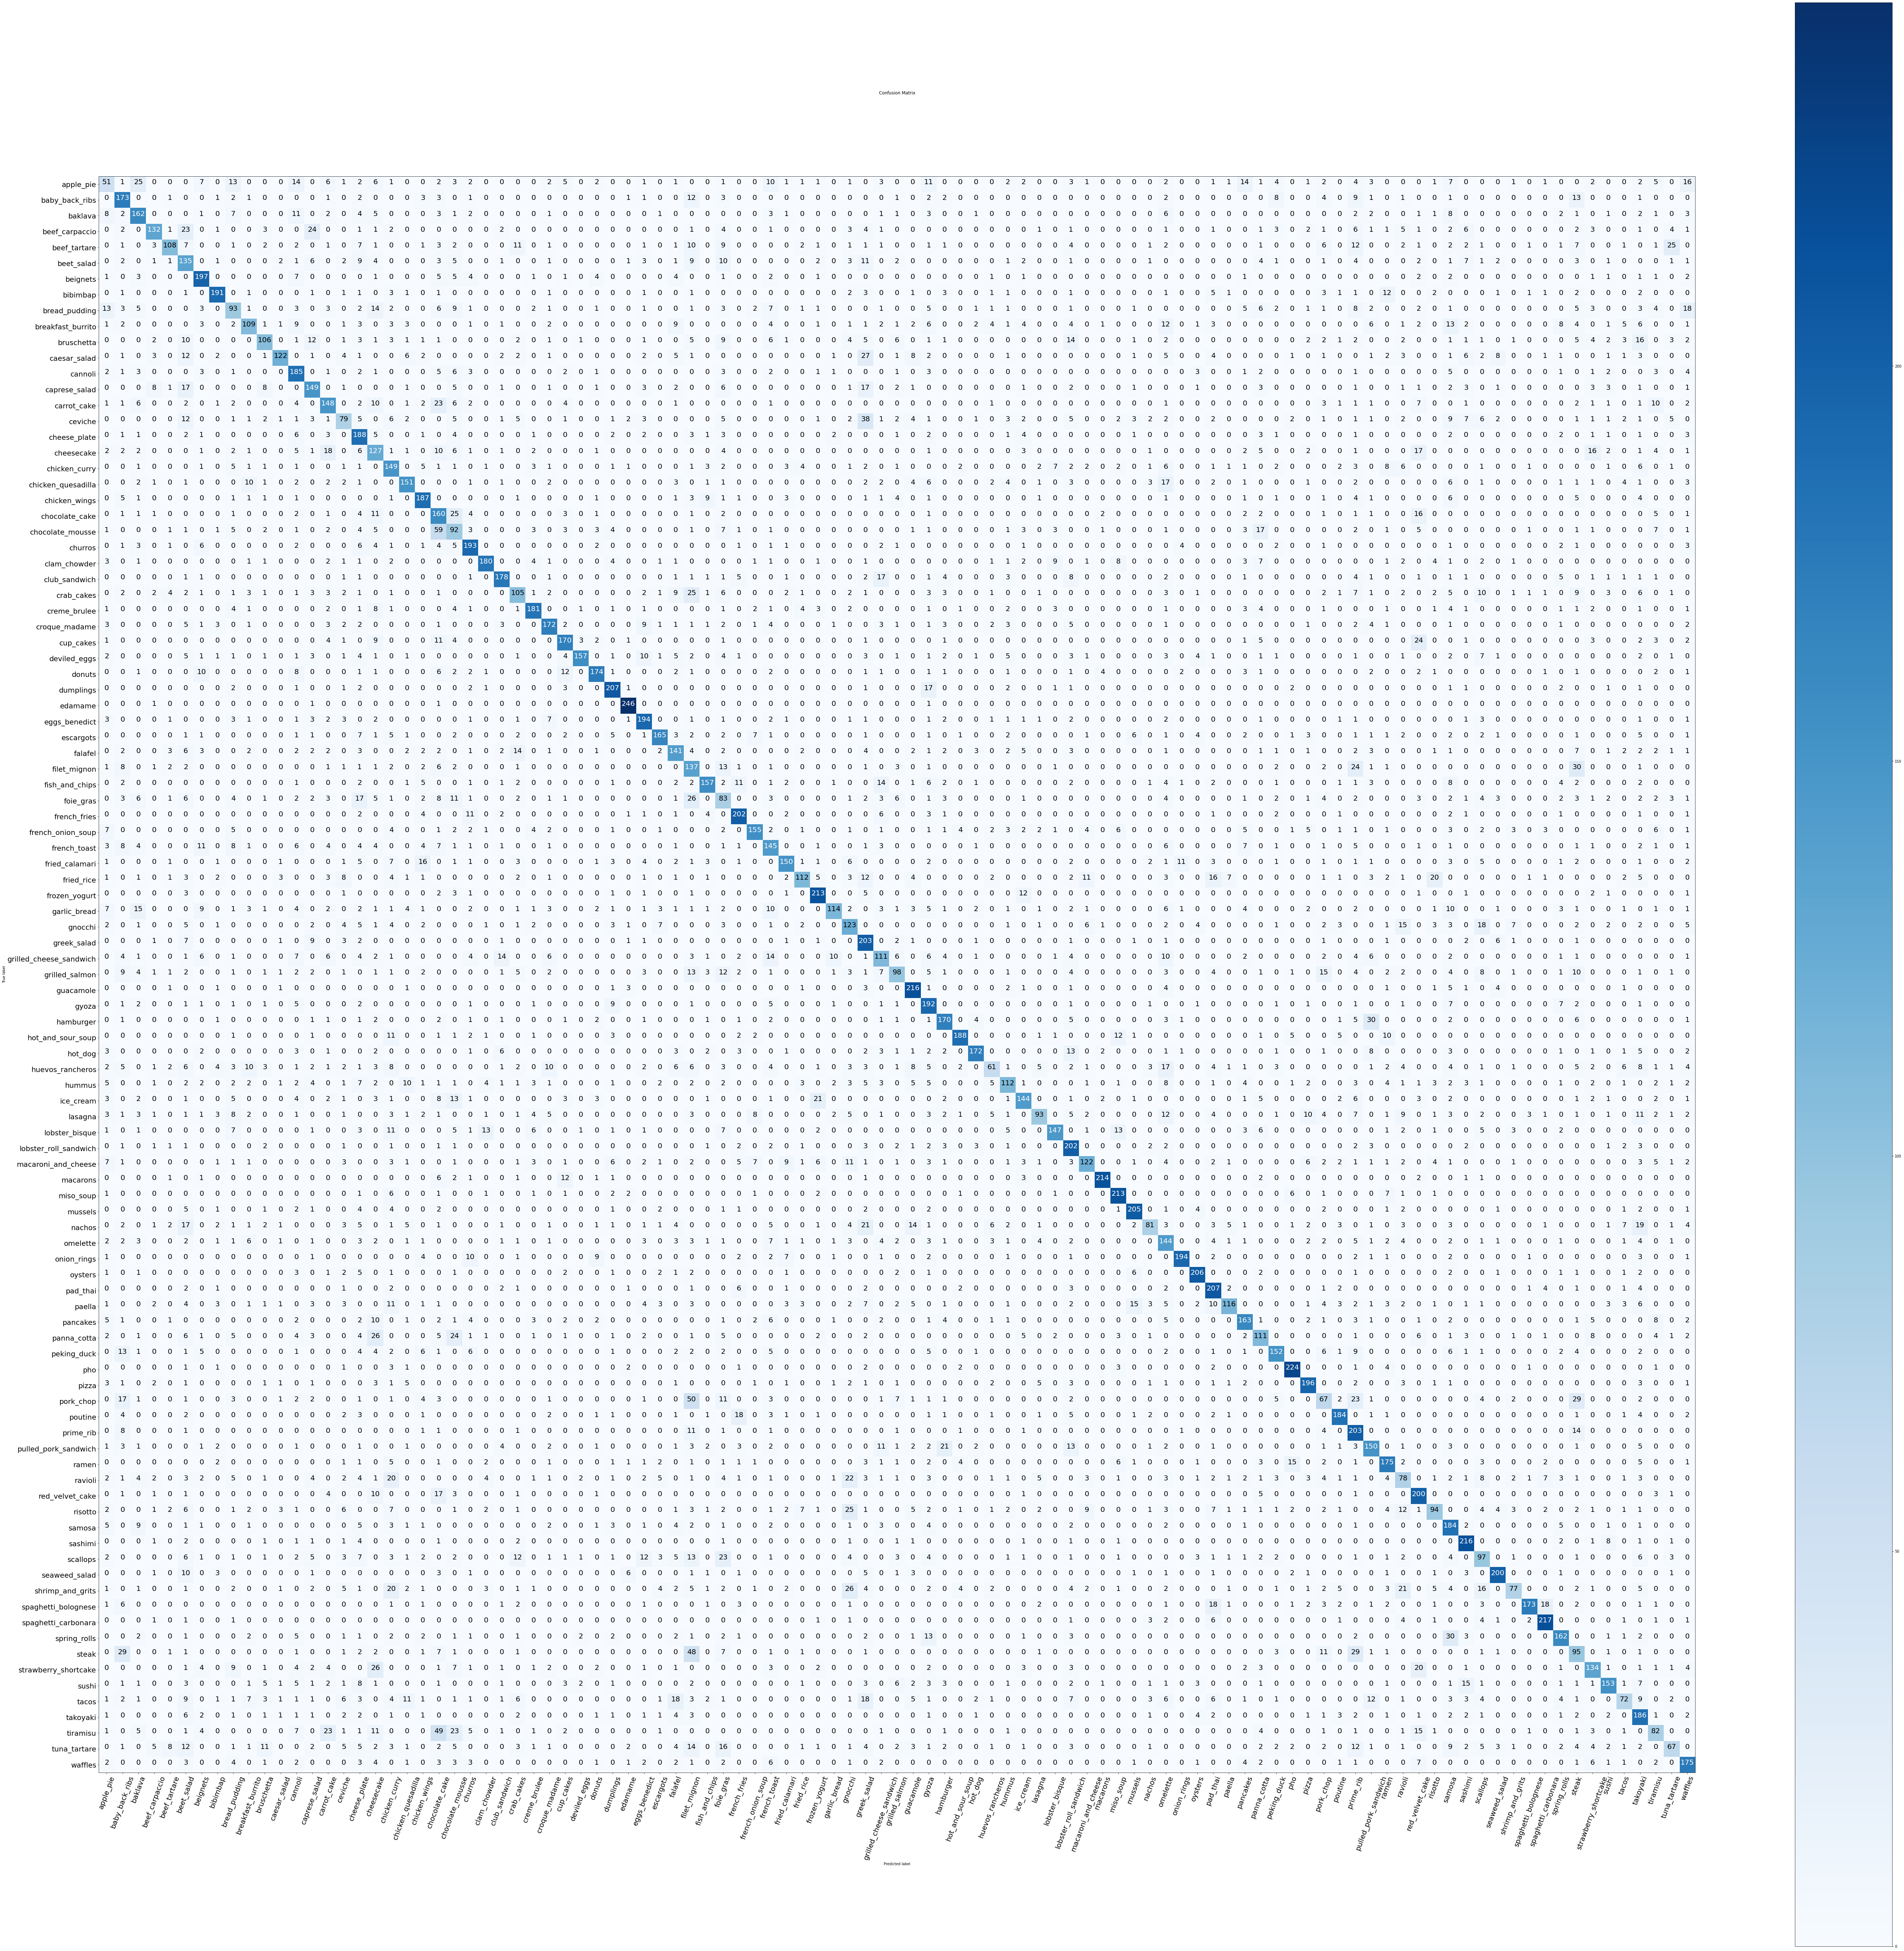

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class ( e.g precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
#  Get a dictironary of the classification report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores...

In [ ]:
class_names[98]

'tiramisu'

In [ ]:

classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [ ]:
# Create empty dictionary

class_f1_scores  = {}

# Loop through classification report dictionary items

for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key,
    break
  else:
    # Addclass_names and f1=scores to new dictionary
    class_f1_scores[class_names[int(k)]]= v["f1-score"]

class_f1_scores




{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())
                          
                          }).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

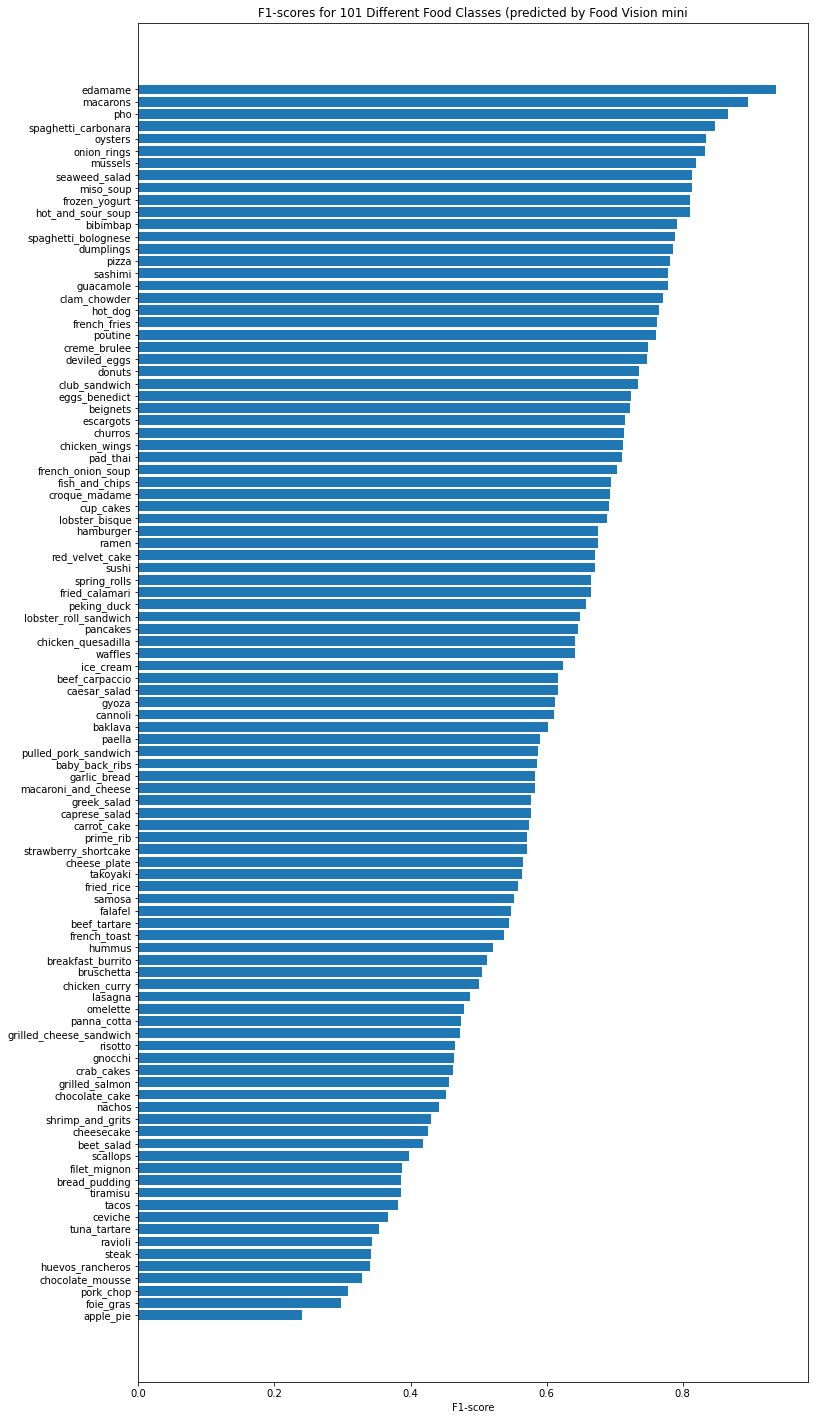

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values

ax.set_yticks(range(len(f1_scores)))

ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")

ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini")

ax.invert_yaxis(); # reverse the order of our plot

# CHallenge: add values to the end of each bar of what the actual f1-score is (hint: use the "autolabel function" from here":https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)


In [ ]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

**Exercise:** Try visualizing some of the most poorly predicted classes(e.g apple_pie, pork_chip), do you notice any trends among them? Why migth our model be having trouble with them?

## Visualizing predictions on test images

Now, this is the real test,  how does our model go on food images not even in our test dataset(images of our own, we'll see this later on).

To visualize our model's predictions on our  own images, we need a function to load and preprocess images', specifically it will need to:

* Read in a target image filepath using tf.io.read_file() "inputs, outputs"

* Turn the image into a Tensor using tf.io.decode_image()

* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()

* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape ( img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor

  img = tf.io.decode_image(img, channels=3)


  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no

  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.

  else:
    return img # don't need to rescale images for EfficientNet models in Tensorflow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

 Specifically, we'll write some code to:
 1. Load a few random images from the test dataset
 2. Make predictions on the loeaded images

 3. Plot the original image(s) along with the model's predictions, predictions  probability and truth label

In [ ]:

train_data_all_10_percent 

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

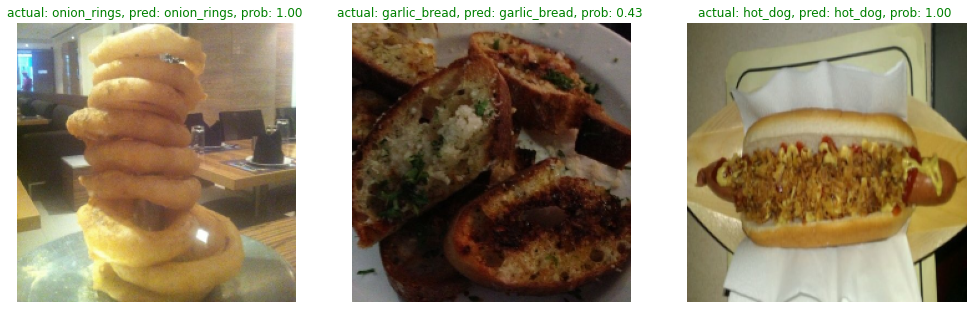

In [76]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):

  # Choose  random image(s) from a random class(es)

  class_name= random.choice(class_names)

  filename = random.choice(os.listdir(test_dir + "/" + class_name))

  filepath = test_dir + class_name + "/" + filename

  # print(filepath)

  # Load the image and make predictions

  img = load_and_prep_image(filepath, scale=False)

  # recordar que debemos transformar las imagenes al formato con el cual fue entrado el modelo (osea expandir en este caso)
  #print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array

  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

  #print(pred_prob)
  #print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i + 1)
  plt.imshow(img/255.)
  if class_name == pred_class:# if predicted class matches thruth class, mkae text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f} ", c=title_color)
  plt.axis(False);


In [ ]:
import random
random.choice(class_names)

'caprese_salad'

In [72]:
test_dir

'101_food_classes_10_percent/test/'

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method

2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.

3. Use our DataFrame to find all the wrong predictions ( where the ground truth label doesn't match the prediction).

4. Sort the DataFrame based on wrong predictions(have the highest prediction probability predictions at the top).

5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [78]:
#1. Get all of the image file paths in the test dataset

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]


                                     

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [79]:
[class_names[i] for i in y_labels[:10]]

['apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie']

In [80]:
# 2. Create a  DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximun prediction probability value
                        "y_true_classname":[class_names[i] for i in y_labels ],
                        "y_pred_classname":[class_names[i] for i in pred_classes]
                        
                        })

pred_df.head()

img_path  ...      y_pred_classname
0  b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1  b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2  b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3  b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4  b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib

[5 rows x 6 columns]

In [81]:
# 3. Find out in our DataFrame which predictions are wrong

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [82]:
#  4. Sort our DataFrame to have most wrong predictions at the top

top_100_wrong = pred_df[pred_df["pred_correct"]== False].sort_values("pred_conf", ascending=False)[:100]

top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

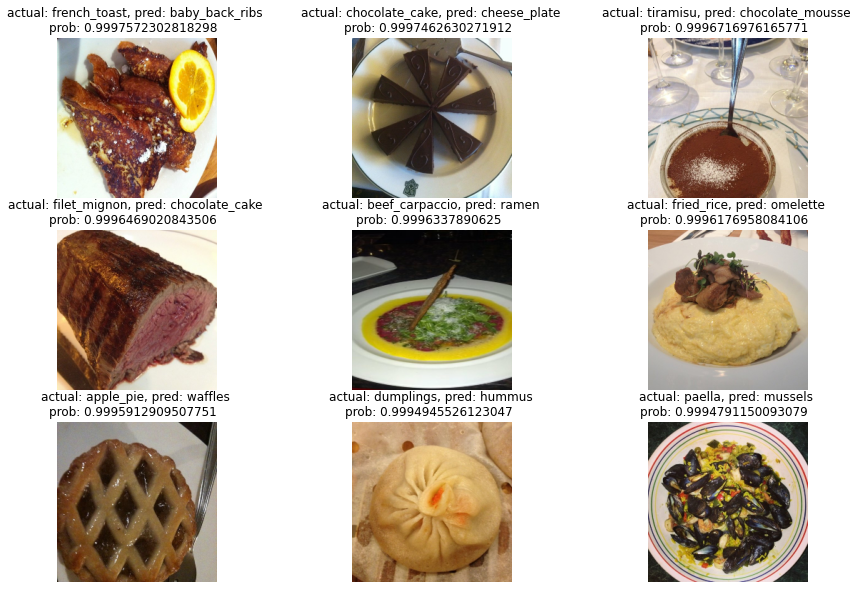

In [86]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9

start_index = 20

plt.figure(figsize=(15, 10))

# A continuacion extraermos informacion de la tabla de arria

# itertuples() me retorna la tupla de lo que hay en una fila osea la informacion de la fila
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  #print(row)
  plt.subplot(3, 3, i+1)
  # en la pocision "1" se encuentra el path
  img = load_and_prep_image(row[1], scale=False)
  # "_," para que salte posiciones, no las tome en cuanta, no me dibuje nada e eso
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row

  plt.imshow(img/255.)
  plt.axis(False)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}  ")



## Test out the big dog model our own custom images

In [87]:
# get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-05-17 17:27:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  22.4MB/s    in 0.6s    

2021-05-17 17:27:23 (22.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [88]:
# Get the custom food images filepaths

# comprension de listas
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]

custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg']

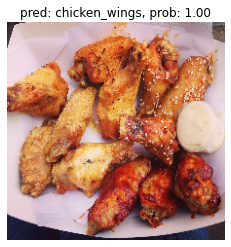

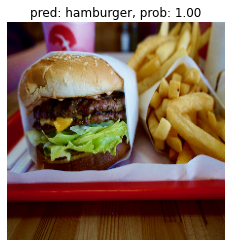

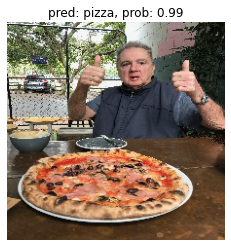

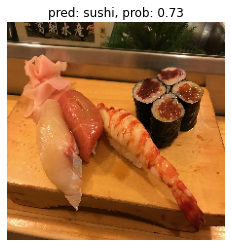

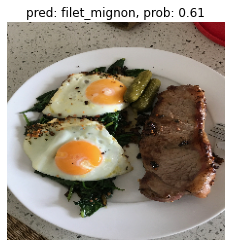

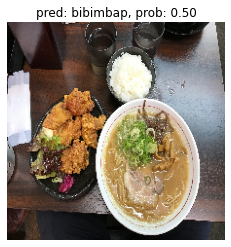

In [89]:
# Make prediction on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0))# make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability

  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)


